In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import xtrack as xt
import xobjects as xo
import matplotlib.pyplot as plt

In [3]:
line = xt.Line.from_json('pimms_02_tuned.json')
line.build_tracker()

Loading line from dict:   0%|          | 0/221 [00:00<?, ?it/s]

Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.


### Build a matched beam distribution

In [4]:
num_particles = 3000
beam_intensity = 1e10 # p+

# Generate Gaussian distribution in normalized phase space
x_norm = np.random.normal(size=num_particles)
px_norm = np.random.normal(size=num_particles)
y_norm = np.random.normal(size=num_particles)
py_norm = np.random.normal(size=num_particles)

# Generate Gaussian momentum distribution (rms spread 5e-4)
delta = 5e-4 * np.random.normal(size=num_particles)

# Assemble Particles object
particles = line.build_particles(
    x_norm=x_norm, px_norm=px_norm, 
    y_norm=y_norm, py_norm=py_norm,
    delta=delta,
    method='4d',
    weight=beam_intensity / num_particles,
    nemitt_x=1.5e-6, nemitt_y=1e-6,
)

# save initial state
p0 = particles.copy()

Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


### Define time-dependent bevior of extraction sextupoles

In [5]:
line.functions['fun_xsext'] = xt.FunctionPieceWiseLinear(x=[0, 0.1e-3, 0.5e-3], y=[0, 0, 1.])

line.vars['kse1'] *= line.functions['fun_xsext'](line.vars['t_turn_s'])
line.vars['kse2'] *= line.functions['fun_xsext'](line.vars['t_turn_s'])

# Inspect the expression
line.vars['kse1']._expr

(4.948275143446286 * f['fun_xsext'](vars['t_turn_s']))

### Set realistic septum aperture

In [6]:
line['septum_aperture'].max_x = 0.035

### Switch to multithreaded context to gain speed

In [7]:
line.discard_tracker()
ctx = xo.ContextCpu(omp_num_threads=8)
line.build_tracker(_context=ctx)

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


### Define quantities to be logged during tracking

User can provide arbitrary functions executed at every turn (output is automatically logged).

In [8]:
# User-defined quantity to be logged
def measure_intensity(line, particles):
    mask_alive = particles.state > 0
    intensity = np.sum(particles.weight[mask_alive])
    return intensity

log = xt.Log('kse1', 'kse2',              # vars to be logged
             intensity=measure_intensity) # user-defined function to be logged

### Enable time-dependent vars update for tracking

In [9]:
line.enable_time_dependent_vars = True

### Track!

In [10]:
line.track(particles, num_turns=5000, with_progress=True,
           log=log)

Tracking:   0%|          | 0/5000 [00:00<?, ?it/s]

### Plot logged quantities

<IPython.core.display.Javascript object>


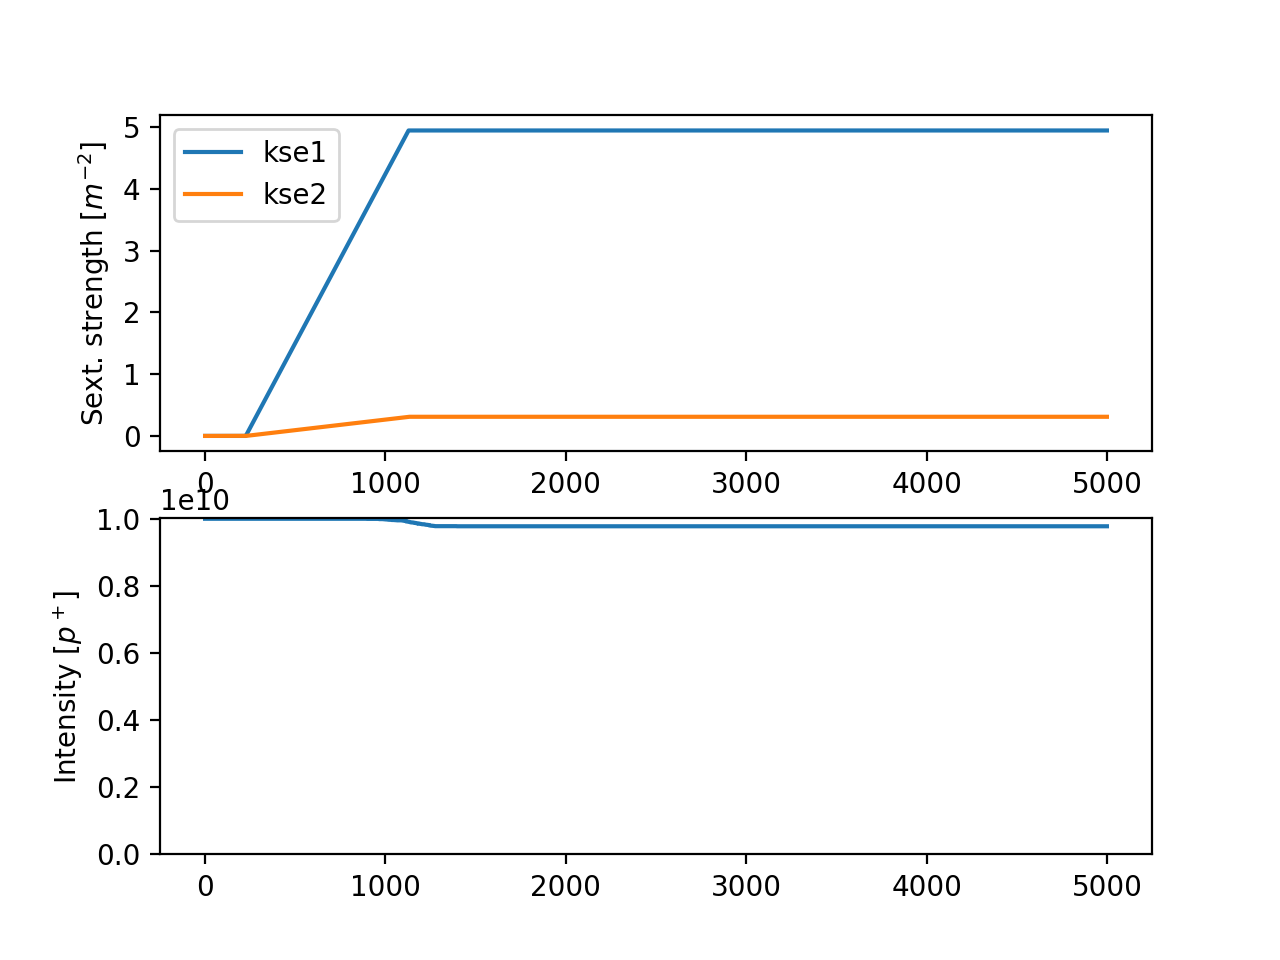

Text(0, 0.5, 'Intensity [$p^+$]')

In [11]:
plt.figure()

ax1 = plt.subplot(2,1,1)
plt.plot(line.log_last_track['kse1'], label='kse1')
plt.plot(line.log_last_track['kse2'], label='kse2')
plt.ylabel('Sext. strength [$m^{-2}$]')
plt.legend()

ax2 = plt.subplot(2,1,2, sharex=ax1)
plt.plot(line.log_last_track['intensity'])
plt.ylim(bottom=0)
plt.ylabel('Intensity [$p^+$]')

### Plot particles after tracking

<IPython.core.display.Javascript object>


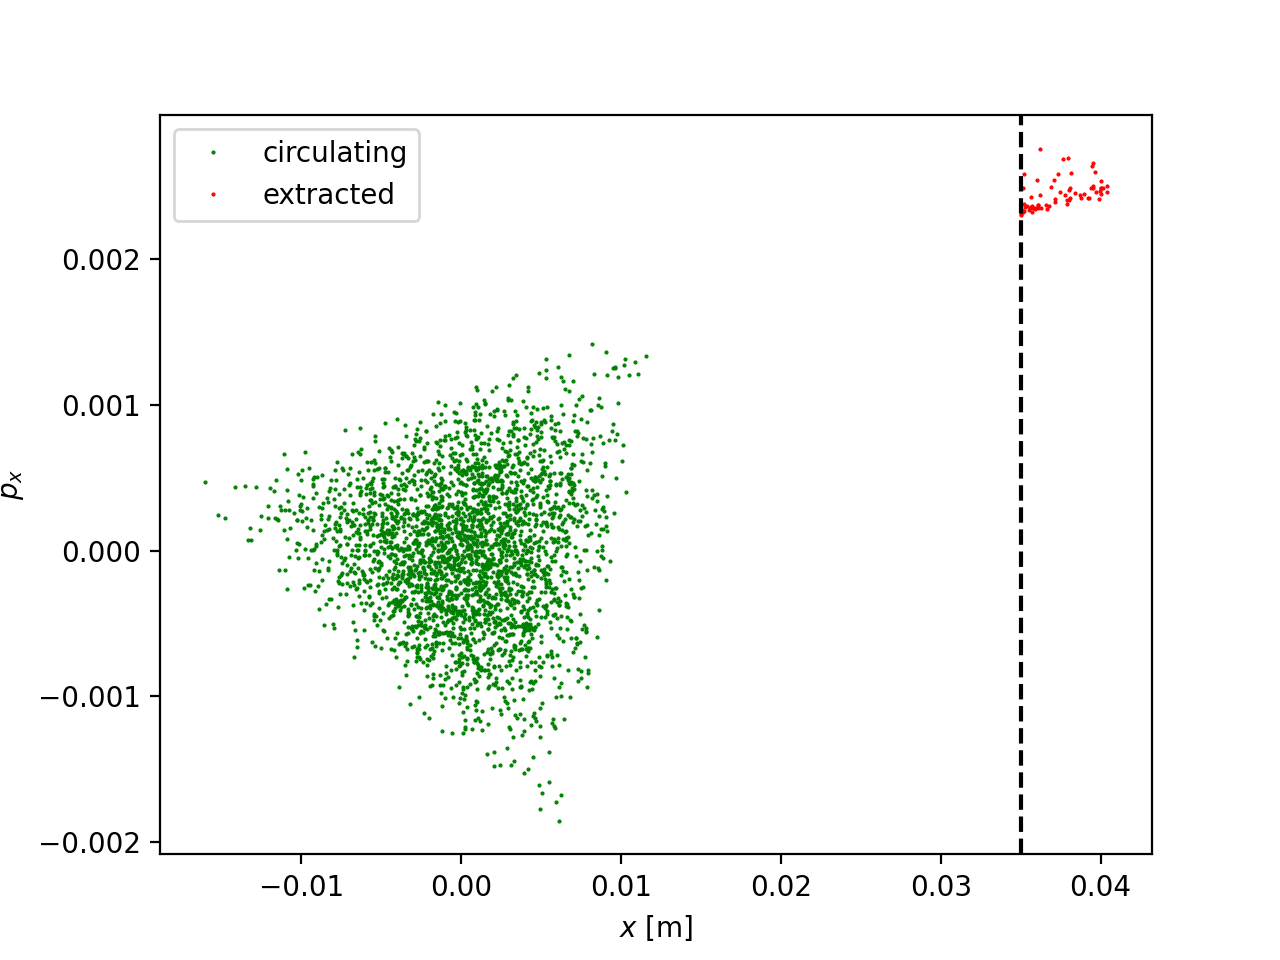

In [12]:
plt.figure()
mask_alive = particles.state>0
mask_lost = ~mask_alive
plt.plot(particles.x[mask_alive], particles.px[mask_alive],
         '.', markersize=1, color='green', label='circulating')
plt.plot(particles.x[mask_lost], particles.px[mask_lost],
         '.', markersize=1, color='red', label='extracted')
plt.xlabel('$x$ [m]'); plt.ylabel('$p_x$')
plt.axvline(x=line['septum_aperture'].max_x, color='k', ls='--')
plt.legend()
plt.show()

## Introduce transverse excitation to control the spill

We build a custom beam element that excites the beam with a white noise and adjusts the ampliude of the noise to keep the desired spill rate.

In [13]:
# Define new element type
class SpillExcitation:
    def __init__(self):
        
        self.amplitude = 0

        self.target_rate = 1e10 / 5000 # Particles per turn
        self.gain = 0
        self.n_ave = 100
        self.tune = .6625

        self._i_turn = 0
        self.intensity = []
        self.rate = []

    def track(self, p):
        
#         if self._i_turn == 1500:
#             self.gain = 0.5e-3
#             self.amplitude = 5e-6 
 
        p.px[p.state > 0] += (
#             self.amplitude * np.random.normal(size=np.sum(p.state > 0)))
            self.amplitude * np.sin(2 * np.pi * self.tune * self._i_turn))
        
        self.intensity.append(np.sum(p.weight[p.state > 0]))
        if self._i_turn > self.n_ave and self.intensity[-1] > 0.1e10:
        
            rate = (self.intensity[self._i_turn - self.n_ave] - self.intensity[self._i_turn]) / self.n_ave
            self.amplitude -= self.amplitude * self.gain * (rate - self.target_rate)/self.target_rate
            
            self.rate.append(rate)

        self._i_turn += 1

In [14]:
# Install the element
line.discard_tracker()
line.insert_element('spill_exc', SpillExcitation(), at_s=0)
line.build_tracker(_context=ctx)

Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


In [136]:
line.functions['fun_excit'] = xt.FunctionPieceWiseLinear(
    x=[0, 0.5e-3, 0.7e-3, 2e-3,   3e-3,    4e-3],
    y=[0, 0,       .8e-5, 1.7e-5, 3e-5,  5e-5])

line.vars['ampl_excit'] = line.functions['fun_excit'](line.vars['t_turn_s'])
line.element_refs['spill_exc'].amplitude = line.vars['ampl_excit']

### Reset the model

In [137]:
# Reset simulation time
line.vars['t_turn_s'] = 0

In [138]:
# Back to initial particles distribution
p = p0.copy()

### Log excitation amplitude

In [139]:
def get_exc_amplitude(line, p):
    return line['spill_exc'].amplitude

log = xt.Log('kse1', 'kse2', 't_turn_s', # vars to be logged
    intensity=measure_intensity,       # user-defined functions to be logged
    excit_amplitude=get_exc_amplitude) 

### Track

In [140]:
line.track(p, num_turns=8000, with_progress=True,
           log=log)

Tracking:   0%|          | 0/8000 [00:00<?, ?it/s]

### Plot logged quantities

<IPython.core.display.Javascript object>


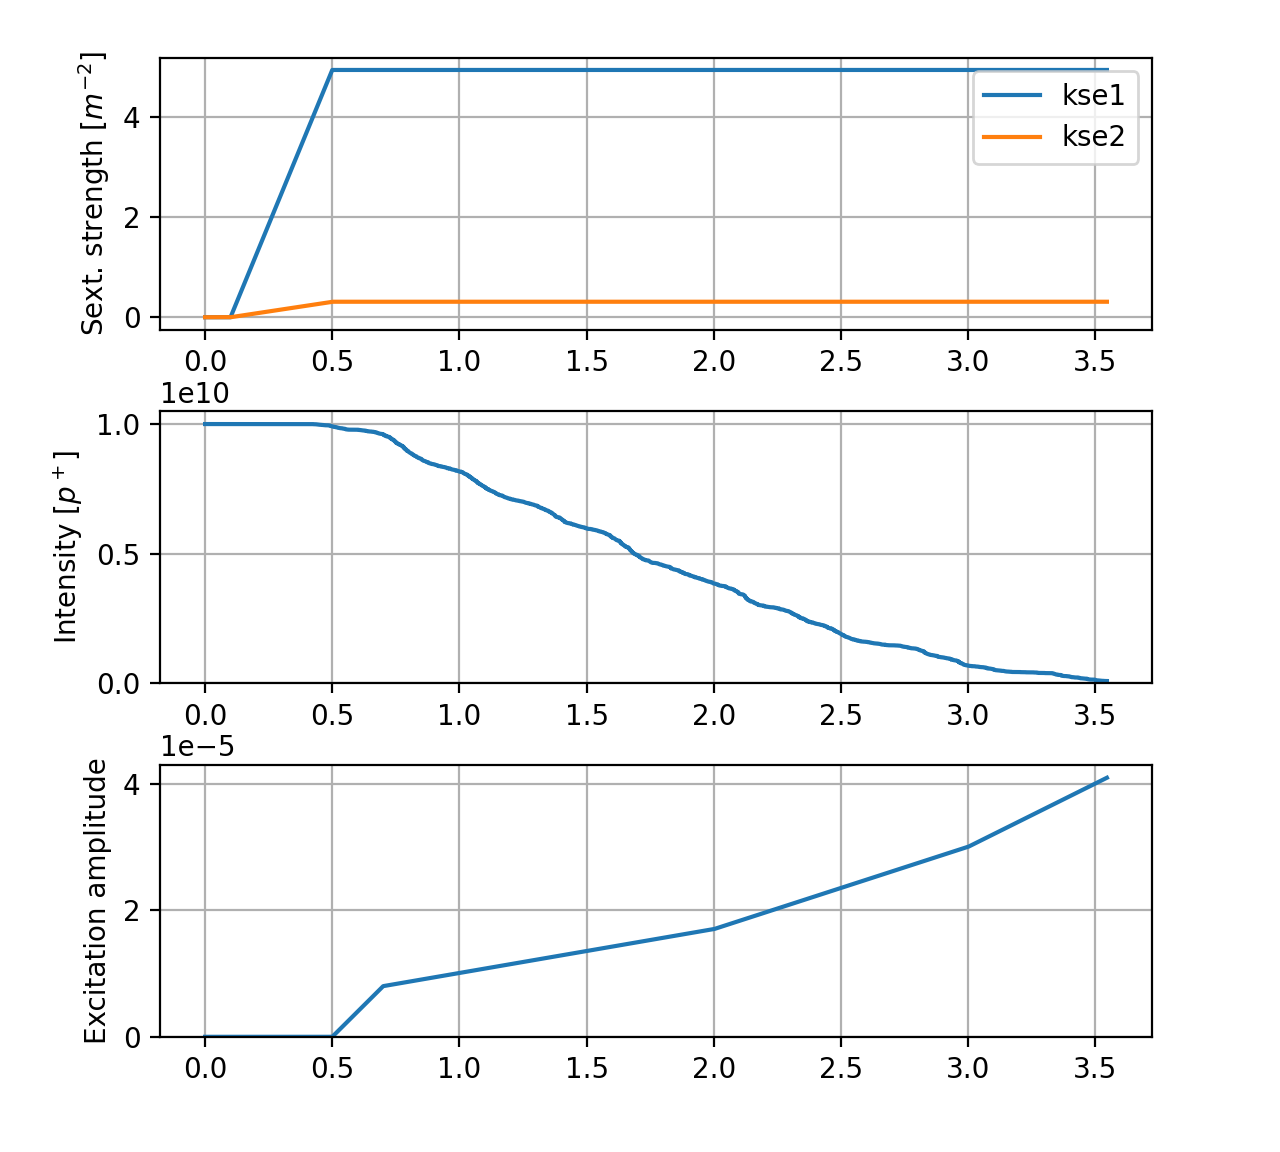

In [141]:
plt.figure(figsize=(6.4, 4.8*1.2))

t_ms = np.array(line.log_last_track['t_turn_s']) * 1e3

ax1 = plt.subplot(3,1,1)
plt.plot(t_ms, line.log_last_track['kse1'], label='kse1')
plt.plot(t_ms, line.log_last_track['kse2'], label='kse2')
plt.ylabel('Sext. strength [$m^{-2}$]')
plt.legend()
plt.grid()

ax2 = plt.subplot(3,1,2, sharex=ax1)
plt.plot(t_ms, line.log_last_track['intensity'])
plt.ylim(bottom=0)
plt.ylabel('Intensity [$p^+$]')
plt.grid()

ax3 = plt.subplot(3,1,3, sharex=ax1)
plt.plot(t_ms, line.log_last_track['excit_amplitude'])
plt.ylim(bottom=0)
plt.ylabel('Excitation amplitude')
plt.grid()

plt.subplots_adjust(top=.95, bottom=.1, hspace=.3)

### Plot particles after tracking

<IPython.core.display.Javascript object>


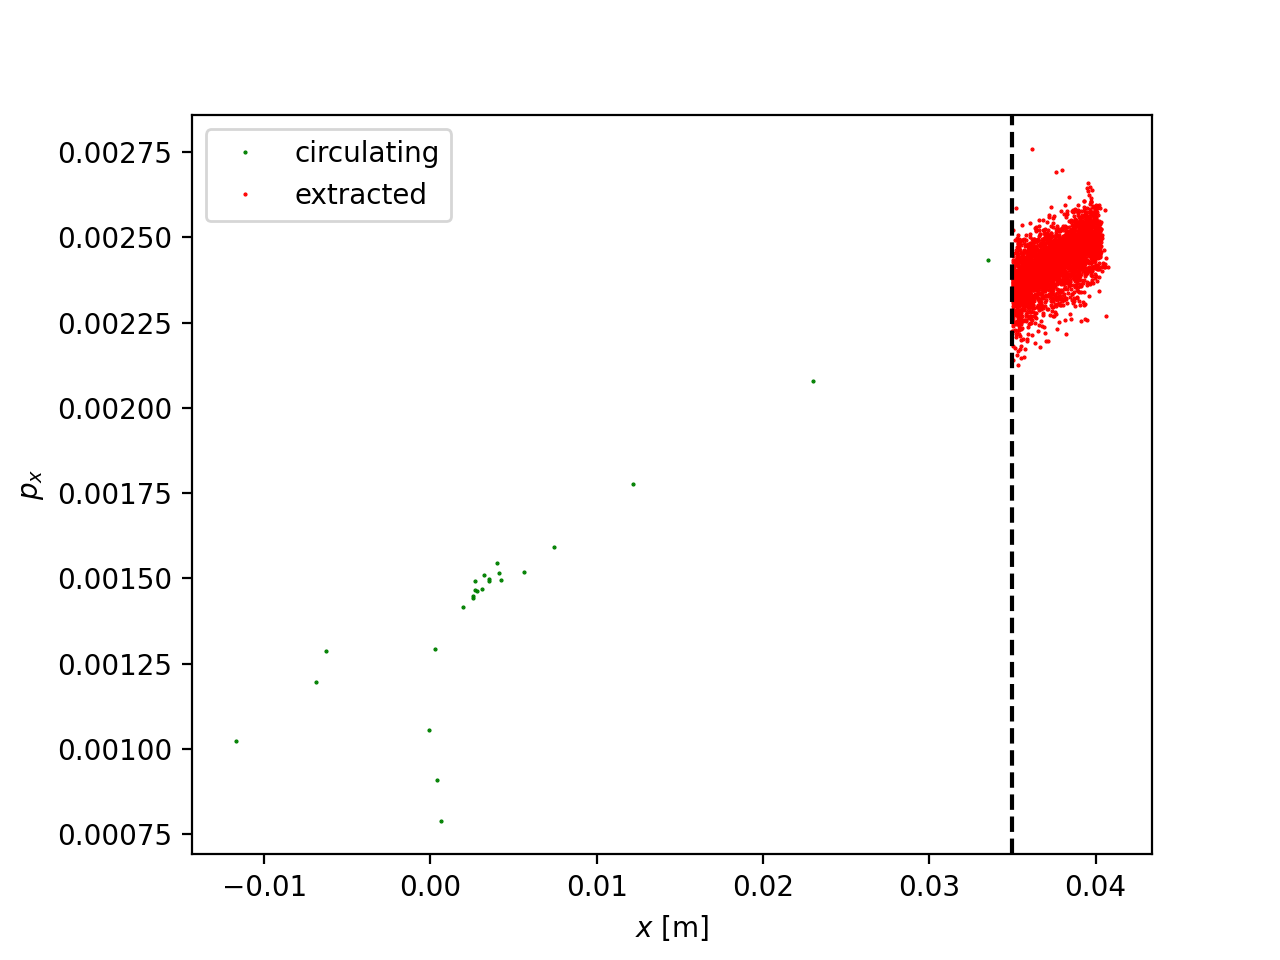

In [142]:
plt.figure()
mask_alive = p.state>0
mask_lost = ~mask_alive
plt.plot(p.x[mask_alive], p.px[mask_alive],
         '.', markersize=1, color='green', label='circulating')
plt.plot(p.x[mask_lost], p.px[mask_lost],
         '.', markersize=1, color='red', label='extracted')
plt.xlabel('$x$ [m]'); plt.ylabel('$p_x$')
plt.axvline(x=line['septum_aperture'].max_x, color='k', ls='--')
plt.legend()
plt.subplots_adjust(left=0.15)
plt.show()

In [65]:
line['spill_exc'].rate[-10:]

[666666.6666666651,
 700000.0,
 700000.0,
 700000.0,
 733333.3333333326,
 733333.3333333326,
 700000.0,
 700000.0,
 700000.0,
 700000.0]